In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu, wilcoxon
from statsmodels.tsa.stattools import acf
import torch
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 120

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [9]:
agent_data = {}
areas = ['all']
for data_class, agent in tqdm(anesthetic_agent_list):
    # if agent == 'propofol':
    #     continue
    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
        cfg.params.grid_set = 'grid_set6'
        # areas = ['all', 'vlPFC', 'FEF', '7b', 'CPB']
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        # bad_session_list = ['PEDRI_Ketamine_20220113', 'PEDRI_Ketamine_20220126', 'PEDRI_Ketamine_20220203', 'PEDRI_Ketamine_20220222', 'SPOCK_Ketamine_20210722', 'SPOCK_Ketamine_20210730']
        # session_list = [session for session in session_list if session not in bad_session_list]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
        # areas = ['all'] if not use_individiual_areas else ['all', 'vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']
        # areas = ['all', 'vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']
        cfg.params.grid_set = 'grid_set6'

        # get only high dose sessions
        high_dose_session_list = []
        for session in session_list:
            session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', session + '.mat'), 'r')
            dose = session_file['sessionInfo']['dose'][0, 0]
            if dose > 9:
                high_dose_session_list.append(session)
        session_list = high_dose_session_list
    
    noise_filter_info = get_noise_filter_info(cfg, session_list, areas, verbose=False)

    agent_data[(data_class, agent)] = {'session_list': session_list}
    session_lists, locs, rocs, ropaps = get_all_session_loc_roc_info(cfg, session_list, verbose=False)
    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['n_delays_vals'] = cfg.grid_sets[cfg.params.grid_set].n_delays_vals
    pca_chosen = get_pca_chosen(cfg, session_list, areas, noise_filter_info, verbose=False)
    agent_data[(data_class, agent)]['pca_chosen'] = pca_chosen

    delase_hparam_results = get_delase_hyperparam_results(cfg, session_list, areas, pca_chosen, agent_data[(data_class, agent)]['n_delays_vals'], verbose=True)
    agent_data[(data_class, agent)]['delase_hparam_results'] = delase_hparam_results

  0%|          | 0/3 [00:00<?, ?it/s]

Loading DeLASE hyperparam results:   0%|          | 0/17340 [00:00<?, ?it/s]

--------------------
SESSION = MrJones-Anesthesia-20160125-01
--------------------
Loading hyperparam data for MrJones-Anesthesia-20160125-01 - all - n_delays 1 from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/propofolPuffTone/delase_hyperparam_results/MrJones-Anesthesia-20160125-01/NOISE_FILTERED_15_1_1_1_stride_120/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/STRIDE_120/all/NO_PCA/grid_set6/N_DELAYS_1
Loaded 60/60 files for MrJones-Anesthesia-20160125-01 - all - n_delays 1
Loading hyperparam data for MrJones-Anesthesia-20160125-01 - all - n_delays 2 from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/propofolPuffTone/delase_hyperparam_results/MrJones-Anesthesia-20160125-01/NOISE_FILTERED_15_1_1_1_stride_120/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/STRIDE_120/all/NO_PCA/grid_set6/N_DELAYS_2
Loaded 60/60 files for MrJones-Anesthesia-20160125-01 - all - n_delays 2
Loading hyperparam data for MrJones-Anesthesia-20160125-01 - all - n_

Loading DeLASE hyperparam results:   0%|          | 0/26055 [00:00<?, ?it/s]

--------------------
SESSION = PEDRI_Ketamine_20220106
--------------------
Loading hyperparam data for PEDRI_Ketamine_20220106 - all - n_delays 1 from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/anesthesiaLvrOdd/delase_hyperparam_results/PEDRI_Ketamine_20220106/NOISE_FILTERED_15_1_1_1_stride_120/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/STRIDE_120/all/NO_PCA/grid_set6/N_DELAYS_1
Loaded 113/113 files for PEDRI_Ketamine_20220106 - all - n_delays 1
Loading hyperparam data for PEDRI_Ketamine_20220106 - all - n_delays 2 from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/anesthesiaLvrOdd/delase_hyperparam_results/PEDRI_Ketamine_20220106/NOISE_FILTERED_15_1_1_1_stride_120/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/STRIDE_120/all/NO_PCA/grid_set6/N_DELAYS_2
Loaded 113/113 files for PEDRI_Ketamine_20220106 - all - n_delays 2
Loading hyperparam data for PEDRI_Ketamine_20220106 - all - n_delays 3 from /scratch2/weka/millerlab/eisenaj/Unive

Loading DeLASE hyperparam results:   0%|          | 0/31905 [00:00<?, ?it/s]

--------------------
SESSION = PEDRI_Dexmedetomidine_20220324
--------------------
Loading hyperparam data for PEDRI_Dexmedetomidine_20220324 - all - n_delays 1 from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/anesthesiaLvrOdd/delase_hyperparam_results/PEDRI_Dexmedetomidine_20220324/NOISE_FILTERED_15_1_1_1_stride_120/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/STRIDE_120/all/NO_PCA/grid_set6/N_DELAYS_1
Loaded 160/160 files for PEDRI_Dexmedetomidine_20220324 - all - n_delays 1
Loading hyperparam data for PEDRI_Dexmedetomidine_20220324 - all - n_delays 2 from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/anesthesiaLvrOdd/delase_hyperparam_results/PEDRI_Dexmedetomidine_20220324/NOISE_FILTERED_15_1_1_1_stride_120/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/STRIDE_120/all/NO_PCA/grid_set6/N_DELAYS_2
Loaded 160/160 files for PEDRI_Dexmedetomidine_20220324 - all - n_delays 2
Loading hyperparam data for PEDRI_Dexmedetomidine_20220324 - all 

In [20]:
stability_means = {}
aic_means = {}
mse_means = {}

top_percents = np.arange(0.01, 0.305, 0.01)
top_percents[9] = 0.1

dose = 'high'

rank_vals = cfg.grid_sets[cfg.params.grid_set].rank_vals

for data_class, agent in anesthetic_agent_list:
    print('--------------------------------')
    print(agent)
    print('--------------------------------')
    cfg.params.data_class = data_class
    iterator = tqdm(total=len(agent_data[(data_class, agent)]['session_list'])*len(areas)*len(agent_data[(data_class, agent)]['n_delays_vals'])*len(rank_vals)*3)
    stability_means[(data_class, agent)] = {}
    aic_means[(data_class, agent)] = {}
    mse_means[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        stability_means[(data_class, agent)][monkey] = {}
        aic_means[(data_class, agent)][monkey] = {}
        mse_means[(data_class, agent)][monkey] = {}
        for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
            section_info, _, _, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
            stability_means[(data_class, agent)][monkey][session] = {}
            aic_means[(data_class, agent)][monkey][session] = {}
            mse_means[(data_class, agent)][monkey][session] = {}
            for area in areas:
                stability_means[(data_class, agent)][monkey][session][area] = {}
                aic_means[(data_class, agent)][monkey][session][area] = {}
                mse_means[(data_class, agent)][monkey][session][area] = {}
                for n_delays in agent_data[(data_class, agent)]['n_delays_vals']:
                    stability_means[(data_class, agent)][monkey][session][area][n_delays] = {} 
                    aic_means[(data_class, agent)][monkey][session][area][n_delays] = {}
                    mse_means[(data_class, agent)][monkey][session][area][n_delays] = {}
                    n_delays_df = agent_data[(data_class, agent)]['delase_hparam_results'][session][area][n_delays]
                    for rank in rank_vals:
                        stability_means[(data_class, agent)][monkey][session][area][n_delays][rank] = {}
                        aic_means[(data_class, agent)][monkey][session][area][n_delays][rank] = {}
                        mse_means[(data_class, agent)][monkey][session][area][n_delays][rank] = {}
                        rank_df = n_delays_df[n_delays_df['rank'] == rank]
                        for section in ['Awake', 'Anesthesia', 'Emergence']:
                            section_start, section_end = section_info[np.where([s[0] == section for s in section_info])[0][0]][1]
                            section_start = section_start*60 + infusion_start
                            section_end = section_end*60 + infusion_start
                            section_df = rank_df[(rank_df['window_start'] >= section_start) & (rank_df['window_start'] <= section_end)]
                            aic_means[(data_class, agent)][monkey][session][area][n_delays][rank][section] = section_df.aic_val.mean()
                            mse_means[(data_class, agent)][monkey][session][area][n_delays][rank][section] = section_df.mse_val.mean()
                            stability_means[(data_class, agent)][monkey][session][area][n_delays][rank][section] = {}
                            for top_percent in top_percents:
                                stability_means[(data_class, agent)][monkey][session][area][n_delays][rank][section][top_percent] = section_df.stability_params.apply(lambda x: x[:min(int(top_percent*len(x)), rank)].mean()).mean()

                            iterator.update(1)
    iterator.close()

--------------------------------
propofol
--------------------------------


  0%|          | 0/77490 [00:00<?, ?it/s]

--------------------------------
ketamine
--------------------------------


  0%|          | 0/59040 [00:00<?, ?it/s]

--------------------------------
dexmedetomidine
--------------------------------


  0%|          | 0/59040 [00:00<?, ?it/s]

In [21]:
aic_maps = {}
mse_maps = {}
stability_maps = {}
area = 'all'
wilcoxon_p_vals_awake_anesthesia = {}
wilcoxon_p_vals_awake_emergence = {}
weighted_stab_maps = {}
for data_class, agent in anesthetic_agent_list:
    aic_maps[(data_class, agent)] = {}
    mse_maps[(data_class, agent)] = {}
    stability_maps[(data_class, agent)] = {}
    weighted_stab_maps[(data_class, agent)] = {}
    wilcoxon_p_vals_awake_anesthesia[(data_class, agent)] = {}
    wilcoxon_p_vals_awake_emergence[(data_class, agent)] = {}
    print('--------------------------------')
    print(agent)
    print('--------------------------------')
    cfg.params.data_class = data_class
    n_delays_vals = agent_data[(data_class, agent)]['n_delays_vals']
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        sessions = agent_data[(data_class, agent)]['session_lists'][monkey][dose]
        aic_maps[(data_class, agent)][monkey] = np.zeros((len(n_delays_vals), len(rank_vals), 3, len(sessions)))
        mse_maps[(data_class, agent)][monkey] = np.zeros((len(n_delays_vals), len(rank_vals), 3, len(sessions)))
        weighted_stab_maps[(data_class, agent)][monkey] = {}
        wilcoxon_p_vals_awake_anesthesia[(data_class, agent)][monkey] = {}
        wilcoxon_p_vals_awake_emergence[(data_class, agent)][monkey] = {}
        for i, n_delays in enumerate(n_delays_vals):
            for j, rank in enumerate(rank_vals):
                for k, session in enumerate(sessions):
                    if rank in stability_means[(data_class, agent)][monkey][session][area][n_delays]:
                        aic_maps[(data_class, agent)][monkey][i, j, 0, k] = aic_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Awake']
                        aic_maps[(data_class, agent)][monkey][i, j, 1, k] = aic_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Anesthesia']
                        aic_maps[(data_class, agent)][monkey][i, j, 2, k] = aic_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Emergence']

                        mse_maps[(data_class, agent)][monkey][i, j, 0, k] = mse_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Awake']
                        mse_maps[(data_class, agent)][monkey][i, j, 1, k] = mse_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Anesthesia']
                        mse_maps[(data_class, agent)][monkey][i, j, 2, k] = mse_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Emergence']
        stability_maps[(data_class, agent)][monkey] = {}
        for top_percent in top_percents:
            stability_maps[(data_class, agent)][monkey][top_percent] = np.zeros((len(n_delays_vals), len(rank_vals), 3, len(sessions)))
            for i, n_delays in enumerate(n_delays_vals):
                for j, rank in enumerate(rank_vals):
                    for k, session in enumerate(sessions):
                        if rank in stability_means[(data_class, agent)][monkey][session][area][n_delays]:
                            stability_maps[(data_class, agent)][monkey][top_percent][i, j, 0, k] = stability_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Awake'][top_percent]
                            stability_maps[(data_class, agent)][monkey][top_percent][i, j, 1, k] = stability_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Anesthesia'][top_percent]
                            stability_maps[(data_class, agent)][monkey][top_percent][i, j, 2, k] = stability_means[(data_class, agent)][monkey][session][area][n_delays][rank]['Emergence'][top_percent]

            aic_map = aic_maps[(data_class, agent)][monkey]
            stab_map = stability_maps[(data_class, agent)][monkey][top_percent]

            aic_avg = np.expand_dims(np.nanmean(aic_map, axis=-2), axis=-2)
            min_aic = np.expand_dims(np.nanmin(aic_avg, axis=(0, 1)), axis=(0, 1))
            aic_weights = np.exp(-(aic_avg - min_aic) / 2)
            aic_weights = aic_weights / np.nansum(aic_weights, axis=(0, 1))
            weighted_stab = aic_weights * stab_map
            weighted_stab_maps[(data_class, agent)][monkey][top_percent] = weighted_stab
            weighted_stab_estimate = np.nansum(weighted_stab, axis=(0, 1))

            wilcoxon_p_vals_awake_anesthesia[(data_class, agent)][monkey][top_percent] = wilcoxon(weighted_stab_estimate[0], weighted_stab_estimate[1], alternative='less')
            if agent == 'ketamine':
                alternative = 'greater'
            else:
                alternative = 'less'
            wilcoxon_p_vals_awake_emergence[(data_class, agent)][monkey][top_percent] = wilcoxon(weighted_stab_estimate[0], weighted_stab_estimate[2], alternative=alternative)

--------------------------------
propofol
--------------------------------


/tmp/ipykernel_837144/3865463799.py:52: RuntimeWarning: Mean of empty slice
  aic_avg = np.expand_dims(np.nanmean(aic_map, axis=-2), axis=-2)


--------------------------------
ketamine
--------------------------------
--------------------------------
dexmedetomidine
--------------------------------


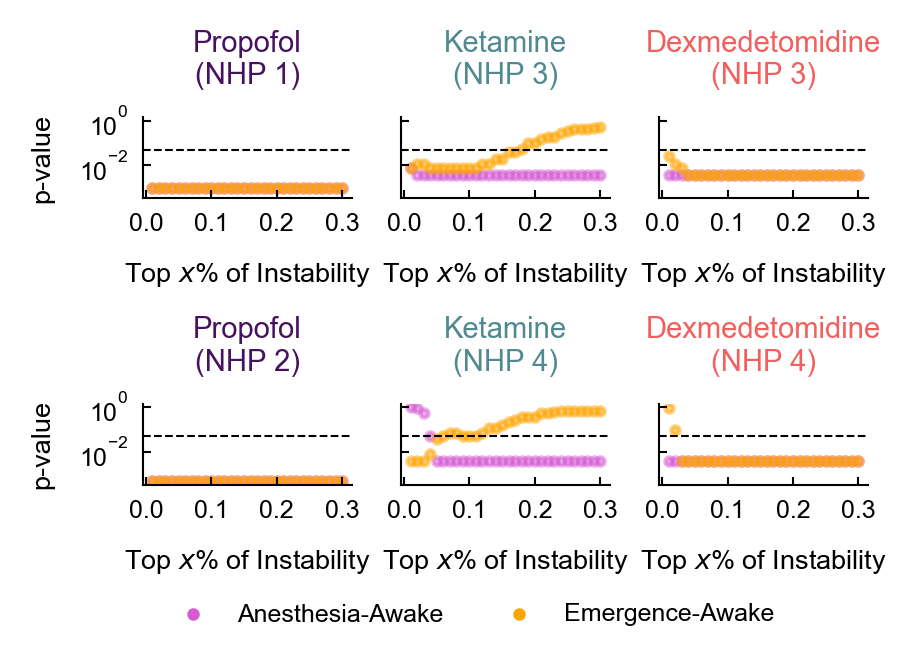

In [42]:
# data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
min_top_percent = 0
max_top_percent = max(top_percents)
fig, axs_all = plt.subplots(2, 3, figsize=(3, 2), sharey=True)
for i, (data_class, agent) in enumerate(anesthetic_agent_list):
    axs = axs_all[:, i]
    for j, monkey in enumerate(agent_data[(data_class, agent)]['session_lists']):
        top_percent_bool = (np.array(top_percents) <= max_top_percent) & (np.array(top_percents) >= min_top_percent)
        p_vals = [wilcoxon_p_vals_awake_anesthesia[(data_class, agent)][monkey][top_percent].pvalue for top_percent in top_percents]
        # print(np.array(p_vals)[top_percents == 0.1][0])
        axs[j].scatter(np.array(top_percents)[top_percent_bool], np.array(p_vals)[top_percent_bool], color=cfg.plotting.epoch_colors['anesthesia'], alpha=0.5)

        p_vals = [wilcoxon_p_vals_awake_emergence[(data_class, agent)][monkey][top_percent].pvalue for top_percent in top_percents]
        # print(np.array(p_vals)[top_percents == 0.1][0])
        axs[j].scatter(np.array(top_percents)[top_percent_bool], np.array(p_vals)[top_percent_bool], color=cfg.plotting.epoch_colors['emergence'], alpha=0.5)
        NHP_num = j+1 if agent == 'propofol' else j+3
        axs[j].set_title(f'{agent.capitalize()}\n(NHP {NHP_num})', color=cfg.plotting.curve_colors[agent], fontsize=7)
        if i == 0:
            axs[j].set_ylabel('p-value')
        axs[j].axhline(0.05, color='k', linestyle='--')
        axs[j].set_yscale('log')
        axs[j].set_xlabel(f'Top $x$% of Instability')
        axs[j].set_xticks([0, 0.1, 0.2, 0.3])

anes_pts = plt.scatter([], [], label='Anesthesia-Awake', color=cfg.plotting.epoch_colors['anesthesia'])
emerg_pts = plt.scatter([], [], label='Emergence-Awake', color=cfg.plotting.epoch_colors['emergence'])

# put legend under figure centered
fig.legend(ncol=2, bbox_to_anchor=(0.52, -0.02), loc='center')
plt.tight_layout()
plt.show()

/tmp/ipykernel_837144/2186628648.py:57: RuntimeWarning: Mean of empty slice
  stab_diffs = np.nanmean(weighted_stab_map[:, :, sec_idx], axis=-1) - np.nanmean(weighted_stab_map[:, :, 0], axis=-1)
/tmp/ipykernel_837144/2186628648.py:57: RuntimeWarning: Mean of empty slice
  stab_diffs = np.nanmean(weighted_stab_map[:, :, sec_idx], axis=-1) - np.nanmean(weighted_stab_map[:, :, 0], axis=-1)
/tmp/ipykernel_837144/2186628648.py:57: RuntimeWarning: Mean of empty slice
  stab_diffs = np.nanmean(weighted_stab_map[:, :, sec_idx], axis=-1) - np.nanmean(weighted_stab_map[:, :, 0], axis=-1)
/tmp/ipykernel_837144/2186628648.py:57: RuntimeWarning: Mean of empty slice
  stab_diffs = np.nanmean(weighted_stab_map[:, :, sec_idx], axis=-1) - np.nanmean(weighted_stab_map[:, :, 0], axis=-1)
/tmp/ipykernel_837144/2186628648.py:57: RuntimeWarning: Mean of empty slice
  stab_diffs = np.nanmean(weighted_stab_map[:, :, sec_idx], axis=-1) - np.nanmean(weighted_stab_map[:, :, 0], axis=-1)
/tmp/ipykernel_837144/218

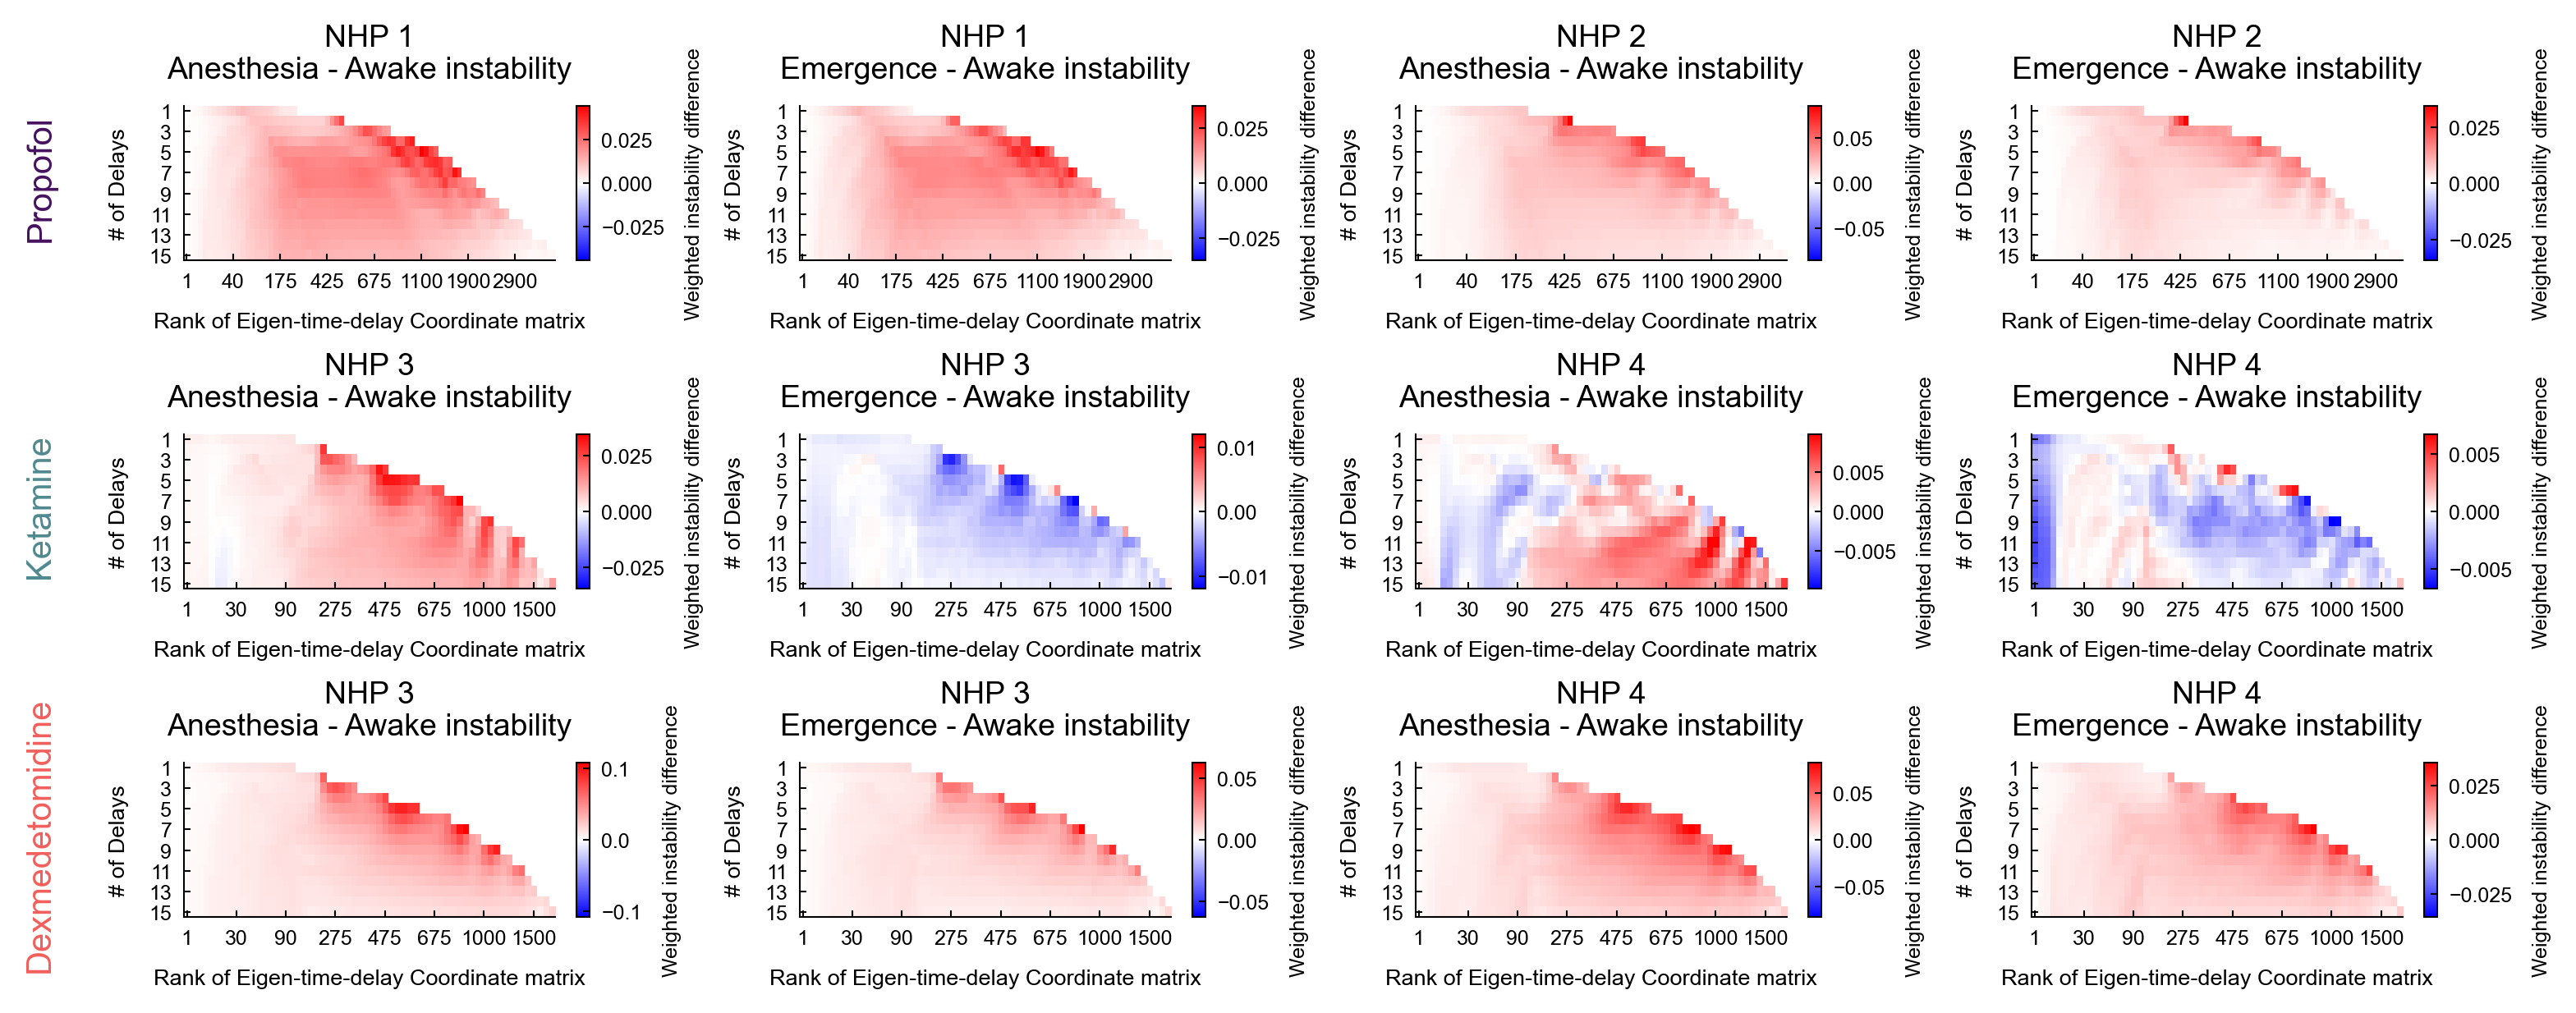

In [35]:
# data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

# Two monkeys per agent, two comparisons per monkey -> four heatmaps per row
# Use dedicated colorbar columns to avoid overlap; add ticks and informative titles
top_percent = 0.1
agents = anesthetic_agent_list
num_rows = len(agents)
# Determine the maximum number of monkeys across agents to size the grid (expect 2)
max_monkeys = max(len(agent_data[(dc, ag)]['session_lists']) for dc, ag in agents)
heatmaps_per_row = max_monkeys * 2  # 2 comparisons per monkey
ncols = heatmaps_per_row * 2  # each heatmap gets a colorbar column
width_ratios = [1, 0.035] * heatmaps_per_row

fig = plt.figure(figsize=(2.5*heatmaps_per_row, 4), constrained_layout=True)
gs = fig.add_gridspec(nrows=num_rows, ncols=ncols, width_ratios=width_ratios, height_ratios=[1]*num_rows)

# Helper to select sparse tick positions to avoid crowding
# Accepts OmegaConf ListConfig by converting to a plain list and uses Python int indices
def sparse_ticks(n_items, labels, target=10):
    labels_list = list(labels)
    step = max(1, int(np.ceil(n_items / target)))
    idx = np.arange(0, n_items, step, dtype=int)
    idx_py = [int(i) for i in idx]
    return idx_py, [str(labels_list[i]) for i in idx_py]

monkey_names = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4'
}

for row_idx, (data_class, agent) in enumerate(agents):
    # Add the agent label to the left of each row with the configured color
    agent_color = curve_colors[agent] if agent in curve_colors else 'k'
    row_center_y = 1.0 - (row_idx + 0.5) / num_rows
    fig.text(-0.03, row_center_y, str(agent).capitalize(), color=agent_color, va='center', ha='left', fontsize=10, fontweight='bold', rotation=90)

    monkeys = list(agent_data[(data_class, agent)]['session_lists'].keys())
    for monkey_idx, monkey in enumerate(monkeys[:max_monkeys]):
        n_delays_vals = agent_data[(data_class, agent)]['n_delays_vals']
        weighted_stab_map = weighted_stab_maps[(data_class, agent)][monkey][top_percent]

        # Build both comparisons for this monkey
        for comp_idx, (sec_idx, title_suffix) in enumerate([
            (1, 'Anesthesia - Awake instability'),
            (2, 'Emergence - Awake instability')
        ]):
            heatmap_idx = monkey_idx*2 + comp_idx  # 0..3 across the row
            heatmap_col = heatmap_idx*2
            cbar_col = heatmap_col + 1
            ax = fig.add_subplot(gs[row_idx, heatmap_col])
            cax = fig.add_subplot(gs[row_idx, cbar_col])

            stab_diffs = np.nanmean(weighted_stab_map[:, :, sec_idx], axis=-1) - np.nanmean(weighted_stab_map[:, :, 0], axis=-1)
            stab_diffs_nans = np.isnan(stab_diffs).sum(axis=0)
            stab_diffs = stab_diffs[:, stab_diffs_nans < stab_diffs.shape[0]]
            max_val = np.nanmax(np.abs(stab_diffs))
            norm = plt.Normalize(vmin=-max_val, vmax=max_val)
            im = ax.imshow(stab_diffs, cmap='bwr', norm=norm, aspect='auto')
            fig.colorbar(im, cax=cax)
            # label the colorbar
            cax.set_ylabel('Weighted instability difference', fontsize=6)
            ax.set_title(f"{monkey_names[monkey]}\n{title_suffix}", fontsize=9)

            # Ticks: y = n_delays, x = rank
            x_idx, x_lbls = sparse_ticks(stab_diffs.shape[1], rank_vals[:stab_diffs.shape[1]], target=8)
            y_idx, y_lbls = sparse_ticks(len(n_delays_vals), n_delays_vals, target=8)
            ax.set_xticks(x_idx)
            ax.set_xticklabels(x_lbls)
            ax.set_yticks(y_idx)
            ax.set_yticklabels(y_lbls)
            ax.set_xlabel('Rank of Eigen-time-delay Coordinate matrix')
            ax.set_ylabel('# of Delays')
plt.show()